In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import matplotlib.pyplot as plt

# Read data

In [2]:
snips_df = pd.read_json("data/snips.json")
snips_df.columns = ["text", "intent"]
snips_df.head()

,text,intent
0,Add another song to the Cita Romántica playlist.,add_to_playlist
1,add clem burke in my playlist Pre-Party R&B Jams,add_to_playlist
2,Add Live from Aragon Ballroom to Trapeo,add_to_playlist
3,add Unite and Win to my night out,add_to_playlist
4,Add track to my Digster Future Hits,add_to_playlist


In [3]:
snips_df['intent'].value_counts()

get_weather               2100
play_music                2100
book_restaurant           2073
search_screening_event    2059
rate_book                 2056
search_creative_work      2054
add_to_playlist           2042
Name: intent, dtype: int64

<Figure size 1080x1080 with 0 Axes>

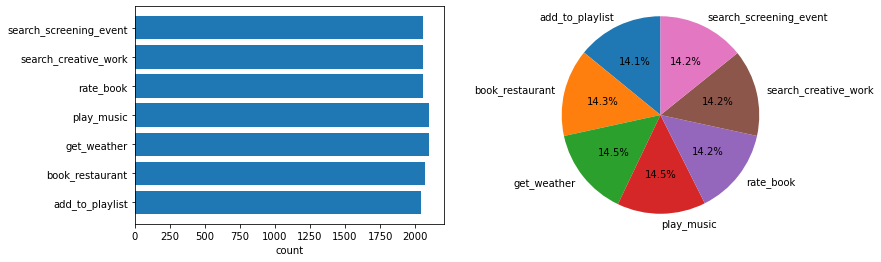

In [4]:
#Plot class distribution

plt.figure(figsize=(15,15))
fig, axs = plt.subplots(1,2)
plt.subplots_adjust(right = 1.7)
grouped = snips_df.groupby("intent").count().reset_index()
axs[0].barh(grouped["intent"], grouped["text"])
axs[0].set_xlabel("count")
axs[1].pie(grouped["text"], labels=grouped["intent"], startangle=90, autopct='%1.1f%%')
axs[1].axis('equal')
plt.savefig("class_dist.jpg", bbox_inches='tight', dpi = 300)
plt.show()

# Prepare data for training

In [5]:
#Split the dataset into train and test

TEST_SPLIT = 0.2
RANDOM_STATE = 10
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(snips_df["text"], snips_df["intent"], 
                                                    test_size = TEST_SPLIT, random_state = RANDOM_STATE)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11587,) (2897,) (11587,) (2897,)


## Feature Extraction

In [6]:
#Initialize a Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(X_train))

#Convert text to sequences
X_seq = tokenizer.texts_to_sequences(list(X_train))
X_test_seq = tokenizer.texts_to_sequences(list(X_test))

In [7]:
X_seq_len = [len(x) for x in X_seq]
X_max_seq_len = max(X_seq_len)
print(X_max_seq_len)

X_test_seq_len = [len(x) for x in X_test_seq]
X_max_test_seq_len = max(X_test_seq_len)
print(X_max_test_seq_len)

MAX_SEQ_LEN = max(X_max_seq_len, X_max_test_seq_len)
print(MAX_SEQ_LEN)

35
32
35


In [8]:
# MAX_SEQ_LEN = 35

#pad the sequences
X = pad_sequences(X_seq, maxlen = MAX_SEQ_LEN, padding = 'post')
X_test = pad_sequences(X_test_seq, maxlen = MAX_SEQ_LEN, padding = 'post')

print(X.shape, X_test.shape)

(11587, 35) (2897, 35)


In [9]:
#Convert labels to one-hot vectors

y = y_train.to_numpy()
encoder = LabelEncoder()
encoder.fit(y)

encoded_y = encoder.transform(y)
y_train_encoded = utils.to_categorical(encoded_y)

y_test = y_test.to_numpy()
encoded_y_test = encoder.transform(y_test)
y_test_encoded = utils.to_categorical(encoded_y_test)

print(y_train_encoded.shape, y_test_encoded.shape)

(11587, 7) (2897, 7)


# Model Training

In [10]:
VAL_SPLIT = 0.1
BATCH_SIZE = 32
EPOCHS = 7
EMBEDDING_DIM = 16
NUM_UNITS = 16
NUM_CLASSES = len(snips_df['intent'].unique())
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(VOCAB_SIZE)

10399


## LSTM

In [11]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM, input_length = MAX_SEQ_LEN, mask_zero = True))
lstm_model.add(LSTM(NUM_UNITS, activation='relu'))
lstm_model.add(Dense(NUM_CLASSES, activation='softmax'))

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision(), Recall(), 'accuracy'])

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 16)            166384    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 7)                 119       
Total params: 168,615
Trainable params: 168,615
Non-trainable params: 0
_________________________________________________________________


In [12]:
lstm_history = lstm_model.fit(X, y_train_encoded, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 1, validation_split = VAL_SPLIT)


Epoch 1/7
326/326 [==============================] - 10s 25ms/step - loss: 1.7596 - precision: 0.7442 - recall: 0.0585 - accuracy: 0.3502 - val_loss: 0.7296 - val_precision: 0.9913 - val_recall: 0.4892 - val_accuracy: 0.9223
Epoch 2/7
326/326 [==============================] - 6s 17ms/step - loss: 0.5155 - precision: 0.9824 - recall: 0.6840 - accuracy: 0.9437 - val_loss: 0.2692 - val_precision: 0.9801 - val_recall: 0.8913 - val_accuracy: 0.9603
Epoch 3/7
326/326 [==============================] - 5s 16ms/step - loss: 0.2132 - precision: 0.9851 - recall: 0.9100 - accuracy: 0.9725 - val_loss: 0.1658 - val_precision: 0.9838 - val_recall: 0.9448 - val_accuracy: 0.9733
Epoch 4/7
326/326 [==============================] - 5s 17ms/step - loss: 0.1079 - precision: 0.9928 - recall: 0.9644 - accuracy: 0.9868 - val_loss: 0.1846 - val_precision: 0.9789 - val_recall: 0.9586 - val_accuracy: 0.9741
Epoch 5/7
326/326 [==============================] - 6s 18ms/step - loss: 0.0639 - precision: 0.9930 - 

### Plot learning curves

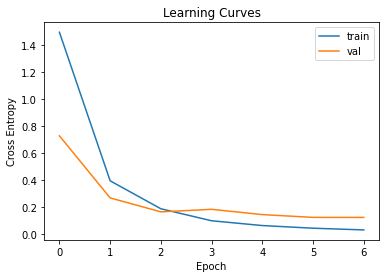

In [13]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(lstm_history.history['loss'], label='train')
plt.plot(lstm_history.history['val_loss'], label='val')
plt.legend()
plt.savefig("learning_curve.jpg", bbox_inches='tight', dpi = 300)
plt.show()

### Predict on test

In [14]:
#Evaluate the model performance on test data
lstm_score = lstm_model.evaluate(X_test, y_test_encoded, batch_size = BATCH_SIZE, verbose = 1)


91/91 [==============================] - 0s 3ms/step - loss: 0.1192 - precision: 0.9884 - recall: 0.9724 - accuracy: 0.9821


### Classification metrics

In [15]:
y_pred_labels_lstm = [encoder.classes_[x] for x in np.argmax(lstm_model.predict(X_test), axis=-1)]
print(metrics.classification_report(y_test, y_pred_labels_lstm))

                        precision    recall  f1-score   support

       add_to_playlist       1.00      0.98      0.99       428
       book_restaurant       0.99      0.99      0.99       394
           get_weather       0.99      1.00      0.99       434
            play_music       0.97      1.00      0.98       410
             rate_book       0.99      0.99      0.99       403
  search_creative_work       0.96      0.95      0.95       411
search_screening_event       0.98      0.97      0.98       417

              accuracy                           0.98      2897
             macro avg       0.98      0.98      0.98      2897
          weighted avg       0.98      0.98      0.98      2897



# Prediction

In [16]:
sentence = "Play music on YouTube Music"
input_seq = tokenizer.texts_to_sequences([sentence])
input_features = pad_sequences(input_seq, maxlen = MAX_SEQ_LEN, padding = 'post')
probs = lstm_model.predict(input_features)
predicted_y = probs.argmax(axis=-1)
print(encoder.classes_[predicted_y][0])

play_music
